In [34]:
import pandas as pd
actions = pd.read_csv('data_test_turnover.csv')

In [36]:
#Load modules
from typing import Callable, List, Tuple
import numpy as np
from pandera.typing import DataFrame, Series
try:
    from scipy.interpolate import interp2d
except ImportError:
    interp2d = None
M: int = 8
N: int = 16

def _get_cell_indexes(x: Series, y: Series, l: int = N, w: int = M) -> Tuple[Series, Series]:
    xmin = 0
    ymin = 0
    xi = (x - xmin) / 200 * l
    yj = (y - ymin) / 85 * w
    xi = xi.astype(int).clip(0, l - 1)
    yj = yj.astype(int).clip(0, w - 1)
    return xi, yj

def _get_flat_indexes(x: Series, y: Series, l: int = N, w: int = M) -> Series:
    xi, yj = _get_cell_indexes(x, y, l, w)
    return l * (w - 1 - yj) + xi

def get_move_actions(actions):
    actions=actions[actions['success'].isna() == False]
    return actions[
        (actions.type_name == 'Zone Entry')
        | (actions.type_name == 'Pass')
    ]

def move_turnover_matrix(actions, l: int = N, w: int = M) -> np.ndarray:
    move_actions = get_move_actions(actions)
    X = pd.DataFrame()
    X['start_cell'] = _get_flat_indexes(move_actions.start_x, move_actions.start_y, l, w)
    X['end_cell'] = _get_flat_indexes(move_actions.end_x, move_actions.end_y, l, w)
    X['success'] = move_actions.success

    vc = X.start_cell.value_counts(sort=False)
    start_counts = np.zeros(w * l)
    start_counts[vc.index] = vc

    turnover_matrix = np.zeros((w * l, w * l))

    for i in range(0, w * l):
        vc2 = X[((X.start_cell == i) & (X.success == 0.0))].end_cell.value_counts(
            sort=False
        )
        turnover_matrix[i, vc2.index] = vc2 / start_counts[i]

    return turnover_matrix

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from PIL import Image
import os

l=16
w=8

cell_coord = []
for n in range(0,w):
    for m in range(0,l):
        cell_coord.append((m,n))

for i in range(0,w*l):
    x=cell_coord[i][0]
    y=cell_coord[i][1]
    uniform_data=pd.DataFrame(move_turnover_matrix(actions, l, w)[i].reshape(w,l))
    uniform_data.loc[y,x] = np.nan
    figure = plt.gcf()
    figure.set_size_inches((200/15), (85/15))
    mask = uniform_data.isnull()
    ax = sns.heatmap(uniform_data,cmap="rocket_r",mask=mask)
    ax.set_facecolor('purple')
    ax.set(
        title = 
        "Shade of red is probability of turning the ball on each cell from "+str(cell_coord[i])
    )
    plt.savefig('gif2_images/'+str(i)+'.png', dpi=100) 
    plt.clf()

files = glob.glob("gif2_images/*.png")
files.sort(key=os.path.getmtime)

fp_out = 'GIF_turnover_matrix.gif'

img, *imgs = [Image.open(f) for f in files]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)

<Figure size 960x408 with 0 Axes>

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from PIL import Image
import os
from xT import ExpectedThreat

xTModel = ExpectedThreat(l, w)
xTModel.fit(actions)
xt = xTModel.xT.reshape(w*l,)

l=16
w=8

cell_coord = []
for n in range(0,w):
    for m in range(0,l):
        cell_coord.append((m,n))

vec = np.zeros(w*l)
vec2 = np.zeros(w*l)
for i in range(0,w*l):
    uniform_data = np.flip(move_turnover_matrix(actions, l, w)[i])
    oxt = (xt * uniform_data).sum()
    nxt = xt[i] - oxt
    vec[i]=nxt
    vec2[i]=oxt
nxt_matrix = vec.reshape(w,l)
oxt_matrix = vec2.reshape(w,l)

# iterations:  16


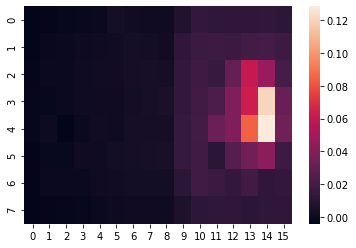

In [38]:
sns.heatmap(nxt_matrix)

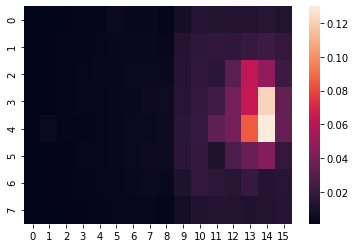

In [39]:
sns.heatmap(xTModel.xT)

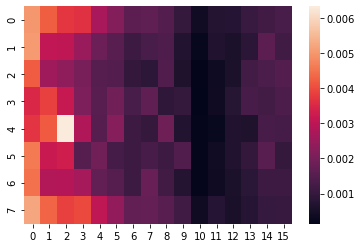

In [40]:
sns.heatmap(oxt_matrix)